<a href="https://colab.research.google.com/github/matfigueiredo/eng-software-int-puc-back/blob/master/Pos_PUC_MVP_Eng_Software.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de Dropout e Sucesso Acadêmico de Estudantes

Este notebook implementa um sistema de machine learning para prever se um estudante irá abandonar o curso (dropout), continuar matriculado (enrolled) ou se formar (graduate) com base em dados demográficos, socioeconômicos e de desempenho acadêmico.

## Contexto do Problema

O dataset contém informações de estudantes de uma instituição de ensino superior portuguesa, incluindo dados conhecidos no momento da matrícula e desempenho acadêmico nos primeiros semestres. O objetivo é identificar estudantes em risco de abandono precocemente para implementar estratégias de suporte.

**Classes do problema:**
- Dropout: Estudante abandonou o curso
- Enrolled: Estudante continua matriculado
- Graduate: Estudante se formou


In [ ]:
# Configuração para não exibir warnings
import warnings
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
warnings.filterwarnings("ignore")



# Configuração de visualização
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline


## Carga do Dataset

Carregamos o dataset diretamente do GitHub usando a URL raw. O dataset contém 4.424 instâncias de estudantes com 36 features cada.


In [ ]:
# URL do dataset no GitHub
url = "https://raw.githubusercontent.com/matfigueiredo/student-dropout-mvp/refs/heads/master/data.csv"

# Carregamento do dataset
dataset = pd.read_csv(url, delimiter=';')

# Limpeza dos nomes das colunas (remover espaços extras e tabs)
dataset.columns = dataset.columns.str.strip()

# Correção específica para a coluna problemática
if 'Daytime/evening attendance\t' in dataset.columns:
    dataset = dataset.rename(columns={'Daytime/evening attendance\t': 'Daytime/evening attendance'})

print(f"Shape do dataset: {dataset.shape}")
print(f"Colunas: {list(dataset.columns)}")

# Visualização das primeiras linhas
dataset.head()


Shape do dataset: (4424, 37)
Colunas: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Análise Exploratória dos Dados

Vamos analisar a estrutura dos dados, distribuição das classes e características principais do dataset.


In [ ]:
# Informações gerais do dataset
print("=== INFORMAÇÕES GERAIS ===")
print(dataset.info())

print("\n=== ESTATÍSTICAS DESCRITIVAS ===")
dataset.describe()


=== INFORMAÇÕES GERAIS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's quali

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


=== DISTRIBUIÇÃO DAS CLASSES ===
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Percentuais:
Target
Graduate    49.932188
Dropout     32.120253
Enrolled    17.947559
Name: count, dtype: float64


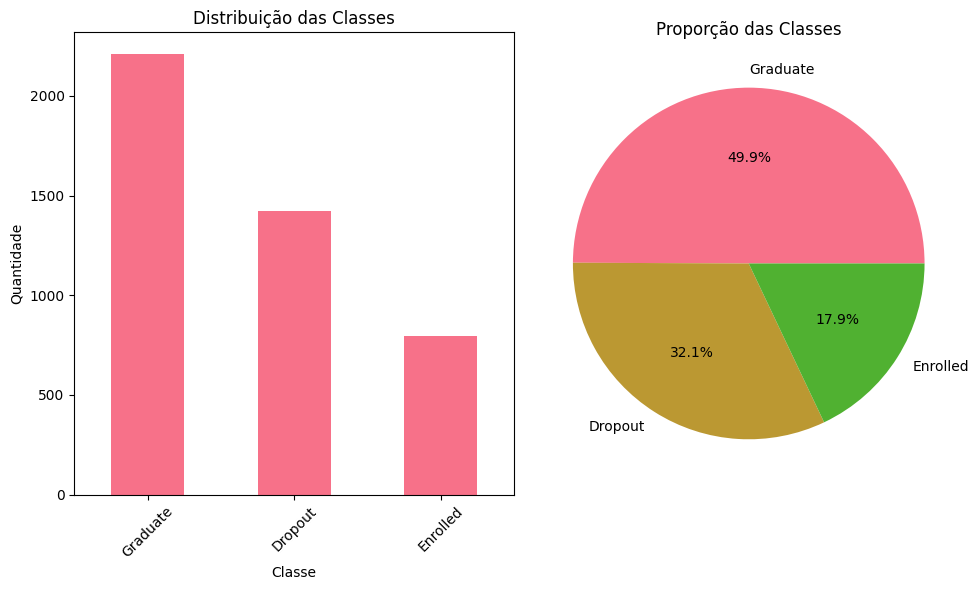

In [ ]:
# Análise da variável target
print("=== DISTRIBUIÇÃO DAS CLASSES ===")
target_counts = dataset['Target'].value_counts()
print(target_counts)
print("\nPercentuais:")
print(target_counts / len(dataset) * 100)

# Visualização da distribuição das classes
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
dataset['Target'].value_counts().plot(kind='bar')
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
dataset['Target'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporção das Classes')
plt.ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
# Verificação de valores faltantes
print("=== VALORES FALTANTES ===")
missing_values = dataset.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("Não há valores faltantes no dataset.")


=== VALORES FALTANTES ===
Não há valores faltantes no dataset.


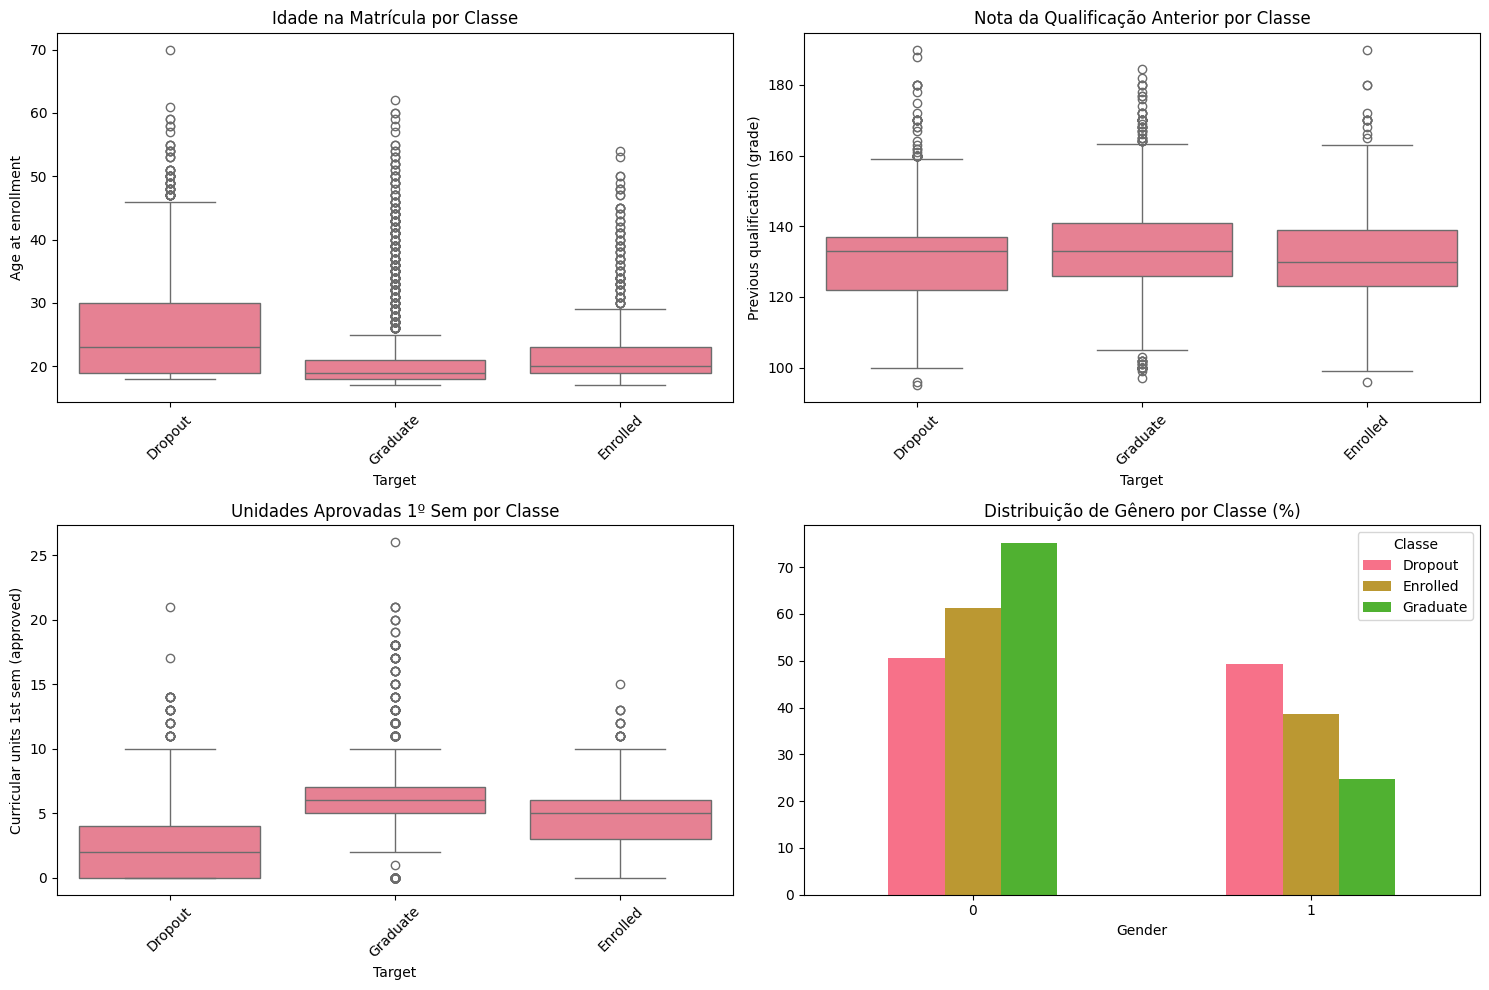

In [ ]:
# Análise de algumas features importantes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age at enrollment por classe
sns.boxplot(data=dataset, x='Target', y='Age at enrollment', ax=axes[0,0])
axes[0,0].set_title('Idade na Matrícula por Classe')
axes[0,0].tick_params(axis='x', rotation=45)

# Previous qualification grade por classe
sns.boxplot(data=dataset, x='Target', y='Previous qualification (grade)', ax=axes[0,1])
axes[0,1].set_title('Nota da Qualificação Anterior por Classe')
axes[0,1].tick_params(axis='x', rotation=45)

# Curricular units 1st sem (approved) por classe
sns.boxplot(data=dataset, x='Target', y='Curricular units 1st sem (approved)', ax=axes[1,0])
axes[1,0].set_title('Unidades Aprovadas 1º Sem por Classe')
axes[1,0].tick_params(axis='x', rotation=45)

# Gender distribution por classe
gender_target = pd.crosstab(dataset['Gender'], dataset['Target'], normalize='columns') * 100
gender_target.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Distribuição de Gênero por Classe (%)')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].legend(title='Classe')

plt.tight_layout()
plt.show()


## Preparação dos Dados

Realizamos a separação das features e target, e preparamos os dados para o treinamento dos modelos.


In [ ]:
# Separação das features e target
X = dataset.drop('Target', axis=1)
y = dataset['Target']

print(f"Shape das features: {X.shape}")
print(f"Shape do target: {y.shape}")
print(f"Classes únicas: {y.unique()}")


Shape das features: (4424, 36)
Shape do target: (4424,)
Classes únicas: ['Dropout' 'Graduate' 'Enrolled']


## Separação em Conjunto de Treino e Teste com Holdout

Utilizamos holdout estratificado para manter a proporção das classes nos conjuntos de treino e teste.


In [ ]:
# Parâmetros da separação
test_size = 0.70  # 70% para teste
seed = 42  # semente para reprodutibilidade

# Separação estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    shuffle=True,
    random_state=seed,
    stratify=y
)

print(f"Conjunto de treino: {X_train.shape[0]} amostras")
print(f"Conjunto de teste: {X_test.shape[0]} amostras")

# Verificação da distribuição das classes após a separação
print("\n=== DISTRIBUIÇÃO NO CONJUNTO DE TREINO ===")
print(y_train.value_counts(normalize=True) * 100)

print("\n=== DISTRIBUIÇÃO NO CONJUNTO DE TESTE ===")
print(y_test.value_counts(normalize=True) * 100)

# Configuração da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)


Conjunto de treino: 1327 amostras
Conjunto de teste: 3097 amostras

=== DISTRIBUIÇÃO NO CONJUNTO DE TREINO ===
Target
Graduate    49.962321
Dropout     32.102487
Enrolled    17.935192
Name: proportion, dtype: float64

=== DISTRIBUIÇÃO NO CONJUNTO DE TESTE ===
Target
Graduate    49.919277
Dropout     32.127866
Enrolled    17.952858
Name: proportion, dtype: float64


## Modelagem e Inferência

Implementamos e comparamos diferentes algoritmos de classificação: KNN, Árvore de Decisão, Naive Bayes e SVM.


### Criação e Avaliação de Modelos: Linha Base

Primeiro, avaliamos os modelos com os dados originais, sem pré-processamento.


=== AVALIAÇÃO DOS MODELOS - DADOS ORIGINAIS ===
KNN: 0.5712 (±0.0300)
Árvore de Classificação: 0.6699 (±0.0321)
Naive Bayes: 0.6624 (±0.0373)
SVM: 0.4898 (±0.0161)


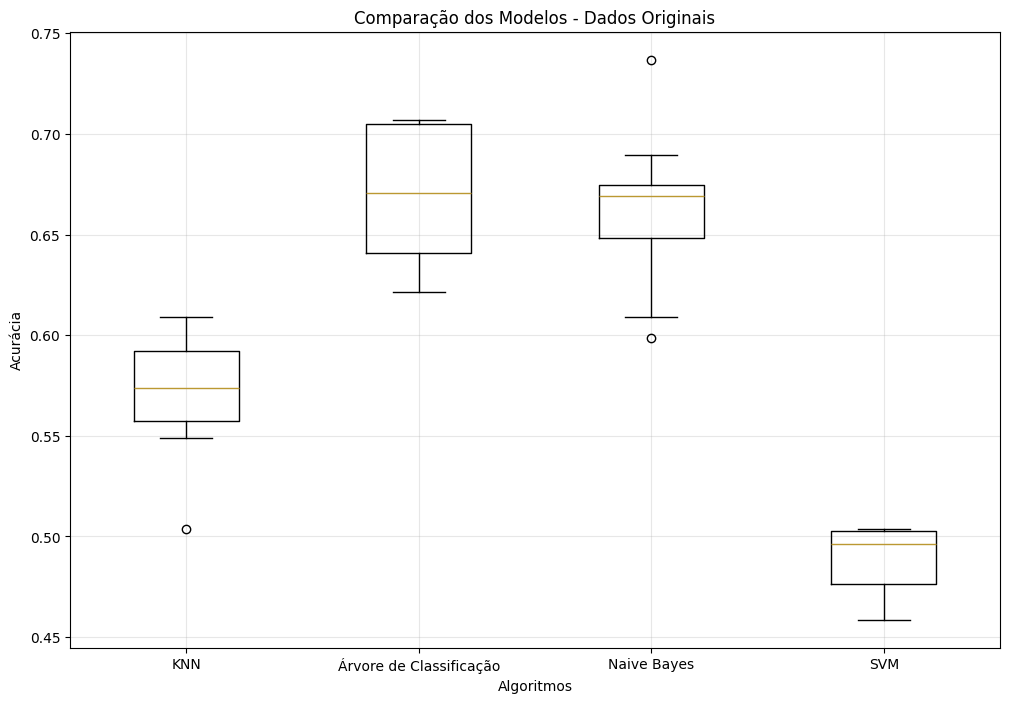

In [ ]:
np.random.seed(seed)

# Lista dos 4 algoritmos obrigatórios
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('Árvore de Classificação', DecisionTreeClassifier(random_state=seed)))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# Listas para armazenar resultados
results = []
names = []

print("=== AVALIAÇÃO DOS MODELOS - DADOS ORIGINAIS ===")

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.4f (±%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
plt.figure(figsize=(12, 8))
plt.boxplot(results, labels=names)
plt.title('Comparação dos Modelos - Dados Originais')
plt.ylabel('Acurácia')
plt.xlabel('Algoritmos')
plt.grid(True, alpha=0.3)
plt.show()


## Pipelines

=== AVALIAÇÃO DOS MODELOS - DIFERENTES TRANSFORMAÇÕES ===
KNN-orig: 0.5712 (±0.0300)
CART-orig: 0.6699 (±0.0321)
NB-orig: 0.6624 (±0.0373)
SVM-orig: 0.4898 (±0.0161)
KNN-padr: 0.6903 (±0.0225)
CART-padr: 0.6676 (±0.0322)
NB-padr: 0.6328 (±0.1372)
SVM-padr: 0.7332 (±0.0220)
KNN-norm: 0.6563 (±0.0350)
CART-norm: 0.6699 (±0.0321)
NB-norm: 0.6328 (±0.1372)
SVM-norm: 0.7151 (±0.0249)


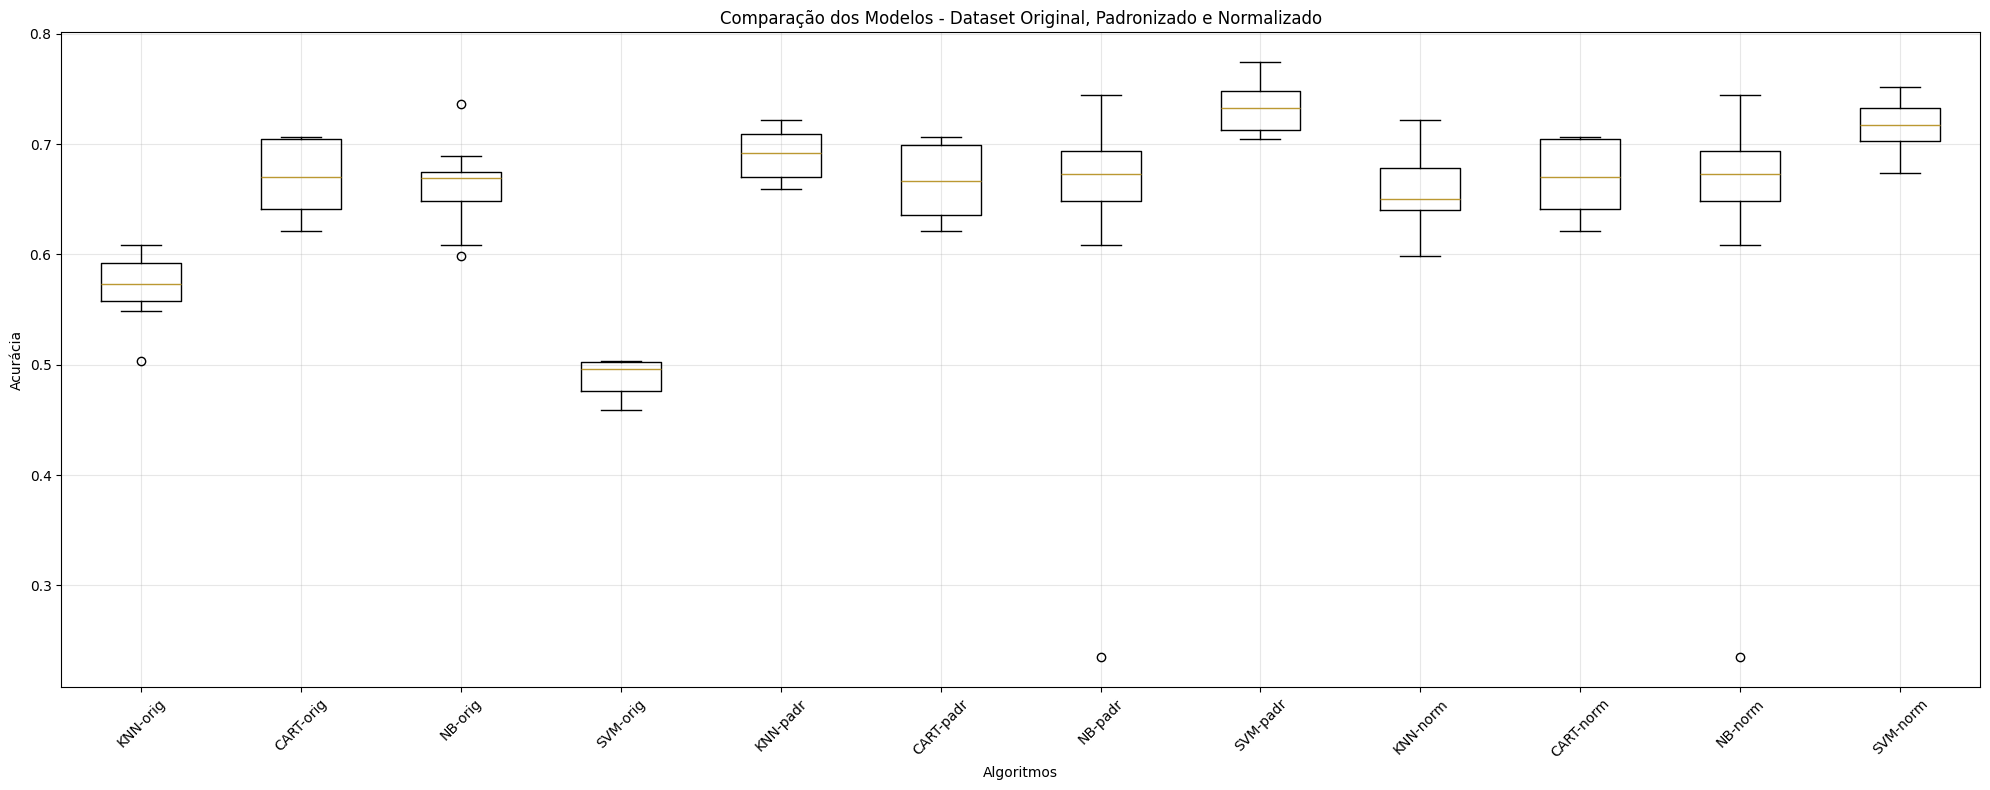

In [ ]:
np.random.seed(seed)

# Listas para armazenar pipelines e resultados
pipelines = []
results = []
names = []

# Algoritmos
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier(random_state=seed))
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC(random_state=seed))

# Transformações
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

print("=== AVALIAÇÃO DOS MODELOS - DIFERENTES TRANSFORMAÇÕES ===")

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.4f (±%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
plt.figure(figsize=(20, 8))
plt.boxplot(results, labels=names)
plt.title('Comparação dos Modelos - Dataset Original, Padronizado e Normalizado')
plt.ylabel('Acurácia')
plt.xlabel('Algoritmos')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Otimização de Hiperparâmetros

Realizamos a otimização dos hiperparâmetros para os melhores modelos identificados na etapa anterior.


In [ ]:
# Tuning do KNN
np.random.seed(seed)

print("=== OTIMIZAÇÃO DE HIPERPARÂMETROS - KNN ===")

pipelines = []
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
    'KNN__weights': ['uniform', 'distance']
}

# Grid search para cada pipeline
best_knn_results = []
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_knn_results.append((name, grid.best_score_, grid.best_params_, grid.best_estimator_))
    print(f"{name} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")

# Encontrar o melhor KNN
best_knn = max(best_knn_results, key=lambda x: x[1])
print(f"\nMelhor KNN: {best_knn[0]} com score {best_knn[1]:.4f}")


=== OTIMIZAÇÃO DE HIPERPARÂMETROS - KNN ===
knn-orig - Melhor: 0.6466 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9, 'KNN__weights': 'distance'}
knn-padr - Melhor: 0.7114 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11, 'KNN__weights': 'uniform'}
knn-norm - Melhor: 0.6933 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17, 'KNN__weights': 'distance'}

Melhor KNN: knn-padr com score 0.7114


In [ ]:
# Tuning da Árvore de Decisão
np.random.seed(seed)

print("=== OTIMIZAÇÃO DE HIPERPARÂMETROS - ÁRVORE DE DECISÃO ===")

cart = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(estimator=cart, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid.fit(X_train, y_train)
best_cart_score = grid.best_score_
best_cart_params = grid.best_params_
best_cart_estimator = grid.best_estimator_
print(f"CART - Melhor: {best_cart_score:.4f} usando {best_cart_params}")


=== OTIMIZAÇÃO DE HIPERPARÂMETROS - ÁRVORE DE DECISÃO ===
CART - Melhor: 0.7370 usando {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [ ]:
# Tuning do SVM
np.random.seed(seed)

print("=== OTIMIZAÇÃO DE HIPERPARÂMETROS - SVM ===")

# SVM com dados padronizados
svm_pipeline = Pipeline([('StandardScaler', StandardScaler()), ('SVM', SVC(random_state=seed))])

param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__kernel': ['linear', 'rbf', 'poly'],
    'SVM__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

grid = GridSearchCV(estimator=svm_pipeline, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid.fit(X_train, y_train)
best_svm_score = grid.best_score_
best_svm_params = grid.best_params_
best_svm_estimator = grid.best_estimator_
print(f"SVM - Melhor: {best_svm_score:.4f} usando {best_svm_params}")

# Tuning do Naive Bayes (simples, sem muitos hiperparâmetros)
np.random.seed(seed)

print("\n=== OTIMIZAÇÃO DE HIPERPARÂMETROS - NAIVE BAYES ===")

# Naive Bayes com dados padronizados
nb_pipeline = Pipeline([('StandardScaler', StandardScaler()), ('NB', GaussianNB())])

param_grid = {
    'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid = GridSearchCV(estimator=nb_pipeline, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid.fit(X_train, y_train)
best_nb_score = grid.best_score_
best_nb_params = grid.best_params_
best_nb_estimator = grid.best_estimator_
print(f"NB - Melhor: {best_nb_score:.4f} usando {best_nb_params}")


=== OTIMIZAÇÃO DE HIPERPARÂMETROS - SVM ===
SVM - Melhor: 0.7513 usando {'SVM__C': 0.1, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}

=== OTIMIZAÇÃO DE HIPERPARÂMETROS - NAIVE BAYES ===
NB - Melhor: 0.6358 usando {'NB__var_smoothing': 1e-05}


## Finalização do Modelo

Selecionamos o melhor modelo baseado nos resultados da otimização e avaliamos sua performance no conjunto de teste.


=== SELEÇÃO AUTOMÁTICA DO MELHOR MODELO ===
Melhor modelo selecionado: SVM
Score de validação cruzada: 0.7513
Modelo: Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('SVM', SVC(C=0.1, kernel='linear', random_state=42))])

=== COMPARAÇÃO FINAL DOS MODELOS ===
KNN: 0.7114
CART: 0.7370
SVM: 0.7513
NB: 0.6358

=== MODELO FINAL: SVM ===
Acurácia no conjunto de teste: 0.7546

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

     Dropout       0.83      0.71      0.76       995
    Enrolled       0.50      0.35      0.42       556
    Graduate       0.77      0.93      0.84      1546

    accuracy                           0.75      3097
   macro avg       0.70      0.66      0.67      3097
weighted avg       0.74      0.75      0.74      3097



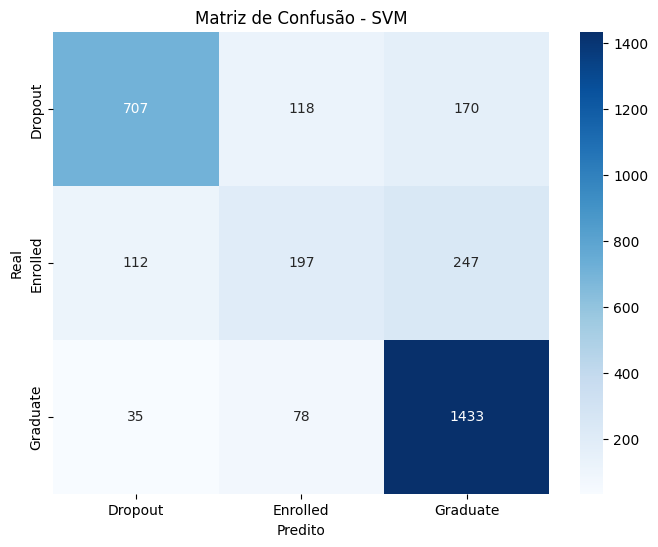

In [ ]:
# Seleção automática do melhor modelo baseado nos resultados
print("=== SELEÇÃO AUTOMÁTICA DO MELHOR MODELO ===")

# Compilar todos os resultados
all_models = [
    ('KNN', best_knn[1], best_knn[3]),
    ('CART', best_cart_score, best_cart_estimator),
    ('SVM', best_svm_score, best_svm_estimator),
    ('NB', best_nb_score, best_nb_estimator)
]

# Encontrar o melhor modelo
best_model_info = max(all_models, key=lambda x: x[1])
best_model_name = best_model_info[0]
best_model_score = best_model_info[1]
best_model = best_model_info[2]

print(f"Melhor modelo selecionado: {best_model_name}")
print(f"Score de validação cruzada: {best_model_score:.4f}")
print(f"Modelo: {best_model}")

print("\n=== COMPARAÇÃO FINAL DOS MODELOS ===")
for name, score, model in all_models:
    print(f"{name}: {score:.4f}")

print(f"\n=== MODELO FINAL: {best_model_name} ===")

# Treinar o melhor modelo no conjunto de treino
best_model.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliação final
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")

# Relatório de classificação
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()


In [ ]:
# Treinamento do modelo final com todo o dataset
print("=== TREINAMENTO FINAL COM TODO O DATASET ===")

# Criar uma cópia do melhor modelo para treinar com todo o dataset
from sklearn.base import clone
model_final = clone(best_model)

# Treinar com todo o dataset
model_final.fit(X, y)

print(f"Modelo final ({best_model_name}) treinado com todo o dataset e pronto para produção!")
print(f"Modelo: {model_final}")


=== TREINAMENTO FINAL COM TODO O DATASET ===
Modelo final (SVM) treinado com todo o dataset e pronto para produção!
Modelo: Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('SVM', SVC(C=0.1, kernel='linear', random_state=42))])


## Exportação do Modelo

Salvamos o modelo treinado e o scaler para uso posterior na aplicação web.


In [ ]:
# Exportação do modelo
joblib.dump(model_final, 'student_dropout_model.pkl')

# Salvar informações do modelo para referência
model_info = {
    'model_name': best_model_name,
    'model_score': best_model_score,
    'test_accuracy': test_accuracy,
    'feature_names': list(X.columns)
}
joblib.dump(model_info, 'student_dropout_model_info.pkl')

print("Modelo salvo com sucesso!")
print("- student_dropout_model.pkl")
print("- student_dropout_model_info.pkl")
print(f"Modelo selecionado: {best_model_name}")
print(f"Features esperadas: {len(X.columns)} colunas")


Modelo salvo com sucesso!
- student_dropout_model.pkl
- student_dropout_model_info.pkl
Modelo selecionado: SVM
Features esperadas: 36 colunas


## Simulação da Aplicação do Modelo

Testamos o modelo com dados simulados para verificar seu funcionamento.


In [ ]:
# Exemplo de novos dados para predição
# Criamos alguns exemplos baseados nas características do dataset

# Primeiro, vamos verificar as colunas exatas do dataset
print("Colunas do dataset original:")
print(list(X.columns))

# Exemplo 1: Estudante com bom desempenho
exemplo_1 = {
    'Marital status': 1,  # solteiro
    'Application mode': 1,  # 1ª fase
    'Application order': 1,  # primeira escolha
    'Course': 9500,  # enfermagem
    'Daytime/evening attendance': 1,  # diurno (SEM ESPAÇO EXTRA)
    'Previous qualification': 1,  # ensino secundário
    'Previous qualification (grade)': 150.0,  # nota alta
    'Nacionality': 1,  # português
    'Mother\'s qualification': 19,  # ensino básico 3º ciclo
    'Father\'s qualification': 19,  # ensino básico 3º ciclo
    'Mother\'s occupation': 7,
    'Father\'s occupation': 9,
    'Admission grade': 140.0,  # nota de admissão alta
    'Displaced': 0,  # não deslocado
    'Educational special needs': 0,  # sem necessidades especiais
    'Debtor': 0,  # não devedor
    'Tuition fees up to date': 1,  # propinas em dia
    'Gender': 0,  # feminino
    'Scholarship holder': 1,  # bolseiro
    'Age at enrollment': 18,  # idade jovem
    'International': 0,  # não internacional
    'Curricular units 1st sem (credited)': 0,
    'Curricular units 1st sem (enrolled)': 8,
    'Curricular units 1st sem (evaluations)': 8,
    'Curricular units 1st sem (approved)': 8,  # aprovou todas
    'Curricular units 1st sem (grade)': 14.0,  # nota alta
    'Curricular units 1st sem (without evaluations)': 0,
    'Curricular units 2nd sem (credited)': 0,
    'Curricular units 2nd sem (enrolled)': 8,
    'Curricular units 2nd sem (evaluations)': 8,
    'Curricular units 2nd sem (approved)': 8,  # aprovou todas
    'Curricular units 2nd sem (grade)': 14.5,  # nota alta
    'Curricular units 2nd sem (without evaluations)': 0,
    'Unemployment rate': 10.8,
    'Inflation rate': 1.4,
    'GDP': 1.74
}

# Exemplo 2: Estudante com risco de dropout
exemplo_2 = {
    'Marital status': 1,
    'Application mode': 17,  # 2ª fase
    'Application order': 5,  # não foi primeira escolha
    'Course': 9254,  # serviço social
    'Daytime/evening attendance': 0,  # noturno (SEM ESPAÇO EXTRA)
    'Previous qualification': 1,
    'Previous qualification (grade)': 100.0,  # nota baixa
    'Nacionality': 1,
    'Mother\'s qualification': 37,  # ensino básico 1º ciclo
    'Father\'s qualification': 37,  # ensino básico 1º ciclo
    'Mother\'s occupation': 9,
    'Father\'s occupation': 9,
    'Admission grade': 105.0,  # nota de admissão baixa
    'Displaced': 0,
    'Educational special needs': 0,
    'Debtor': 1,  # devedor
    'Tuition fees up to date': 0,  # propinas em atraso
    'Gender': 1,  # masculino
    'Scholarship holder': 0,  # não bolseiro
    'Age at enrollment': 25,  # idade mais avançada
    'International': 0,
    'Curricular units 1st sem (credited)': 0,
    'Curricular units 1st sem (enrolled)': 6,
    'Curricular units 1st sem (evaluations)': 3,
    'Curricular units 1st sem (approved)': 2,  # aprovou poucas
    'Curricular units 1st sem (grade)': 10.0,  # nota baixa
    'Curricular units 1st sem (without evaluations)': 3,
    'Curricular units 2nd sem (credited)': 0,
    'Curricular units 2nd sem (enrolled)': 6,
    'Curricular units 2nd sem (evaluations)': 2,
    'Curricular units 2nd sem (approved)': 1,  # aprovou muito poucas
    'Curricular units 2nd sem (grade)': 9.5,  # nota baixa
    'Curricular units 2nd sem (without evaluations)': 4,
    'Unemployment rate': 15.5,
    'Inflation rate': 2.8,
    'GDP': -4.06
}

# Convertendo para DataFrame
novos_dados = pd.DataFrame([exemplo_1, exemplo_2])

# Garantir que as colunas estão na mesma ordem do dataset original
novos_dados = novos_dados[X.columns]

print(f"\nShape dos novos dados: {novos_dados.shape}")
print(f"Colunas dos novos dados: {list(novos_dados.columns)}")

# Fazendo predições
predicoes = model_final.predict(novos_dados)

print("\n=== PREDIÇÕES PARA NOVOS ESTUDANTES ===")

for i, pred in enumerate(predicoes):
    print(f"\nEstudante {i+1}:")
    print(f"  Predição: {pred}")


Colunas do dataset original:
['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', '